# Research on car sales ads

Following tasks would be completed stepwise:
- Checking missing values and dealing with them
- Checking for duplicates and dealing with them
- Required data type conversions
- Adding several columns to answer questions
- Answer the questions of the project accordingly
- Summary of the task!

## 1. Open the data file and study the general information.

In [60]:
#import all necessary packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [61]:
# load the dataset with pandas and get familiar with it by retreiving 5 random rows of it

ads = pd.read_csv('vehicles_us.csv')
ads.sample(5)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
40016,3950,2010.0,ford explorer,excellent,6.0,gas,235689.0,automatic,wagon,grey,1.0,2018-11-18,16
31839,5495,2008.0,ford escape,excellent,6.0,gas,126293.0,automatic,wagon,grey,1.0,2018-12-21,35
29390,41760,2013.0,ram 2500,excellent,6.0,diesel,50426.0,automatic,pickup,grey,1.0,2018-10-09,26
19133,3900,2001.0,chevrolet silverado,good,8.0,gas,225000.0,automatic,truck,grey,1.0,2018-10-30,17
14470,3500,2005.0,nissan murano,good,6.0,gas,156000.0,automatic,SUV,white,NaN,2018-06-29,15


In [62]:
#information about data type of each column, memory usage, and number of non-null rows in each column
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


### 1.1 Conclusion
Required libraries were imported and dataset successfully opened!

Data has ```13 columns``` and ```51525``` rows. From the beginning we can easily see that there are a lot of ```NaN``` values in the data. Another issue with the data is that most of the columns are in ```object``` or ```float64``` type, we will deal with issue in later stages to make our table visually more understandable and save the memory.

## 2. Data preprocessing
First thing first, let's fix the missing value issue and then we will move to deal with duplicates and data type issues.

### 2.1 Missing

In [63]:
# check out the percentages of missing values in each column
ads.isnull().sum()*100/len(ads)

price            0.000000
model_year       7.023775
model            0.000000
condition        0.000000
cylinders       10.208637
fuel             0.000000
odometer        15.316836
transmission     0.000000
type             0.000000
paint_color     17.985444
is_4wd          50.369723
date_posted      0.000000
days_listed      0.000000
dtype: float64

> In total 5 columns out of 13 have a missing values. These missing values most likely originating from the users, people who is placing the advertisement. Several reasons might be behind the issue:
- Maybe people don't know about this feature of their car,
- they don't want to discole it,
- just forgot to fill it,
- this feature is not appropriate for their cars, i.e. usually cars are not 4wd etc.

> **50%** of the **```is_4wd```** column values are missing. However, it is reasonable to this column contains boolean type data, if a vehcile is 4wd then it is 1, otherwise it is NaN. So we can fill NaN values with 0. Filling missing data with 0 instead of dropping this column will allow us to keep a potentially useful feature.

In [64]:
# drop whole *is_4wd* column and check if it worked by observing first 3 rows of the table 
ads['is_4wd'] = ads['is_4wd'].fillna(value=0)
ads.head(3)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,0.0,2019-02-07,79


> Now it's time to fix the other columns missing values one by one. **7%** of values are missing in the model_year column. However, most likely, the model year of a car can be strongly defined by its condition. This means that if the car was built a long time ago, the condition is probably bad. Let's do following steps:
- check our hypothesis, if there is a relation between condition and model_year
- construct a function to fill missing values

In [65]:
# check average, median model years of cars according to their conditions and count how many of them in each condition
ads.pivot_table(index='condition', values='model_year', aggfunc=['mean', 'median', 'count'])

,mean,median,count
,model_year,model_year,model_year
condition,,,
excellent,2010.712490,2012.0,23074
fair,2001.975201,2003.0,1492
good,2008.531639,2009.0,18695
like new,2012.469041,2014.0,4409
new,2014.466165,2018.0,133
salvage,2005.631068,2005.0,103


> Nice, we have a good relation with **```condition```** and **```model_year columns```**. But, due to some extreme values, means are not best option to fill missing values. Therefore, let's fill missing values of **```model_year```** column with median values of cars in each **```condition```**


In [66]:
# construct a function to fill missing values in model_year column according to values of condition column


def model_year_filler(ads):
    condition=ads['condition']
    model_year_is_nan = pd.isna(ads['model_year'])
    if model_year_is_nan:
        if condition == 'excellent':
            return 2012
        elif condition == 'good':
            return 2009
        elif condition == 'like new':
            return 2014
        elif condition == 'new':
            return 2018
        else:
            return 2003
    else:
        return ads['model_year']
    

#apply the function and make a new column then replace old column with new one
missing_filled_model_year=ads.apply(model_year_filler, axis=1)
ads['model_year']=missing_filled_model_year

#check if we succesfully filled all missing values in the colum
ads['model_year'].isnull().sum()

0

> Now, time to fix **```cylinders```** column. Cars are designed depending on their use, i.e. off-road or heavy-duty cars should be powerful, so they are equipped with a high number of cylinders. Based on this, we can assume that **```cylinders```** and **```type```** columns are defining each other.
- Check if that two columns has relationship
- Fill missing values either with mean or median values

In [67]:
# make a pivot table and see mean, median number of cylinders for each car type, count them as well.
type_cylinders_pivot = ads.pivot_table(index='type', values='cylinders',
                                       aggfunc=['mean','median','count']).reset_index()
type_cylinders_pivot

,type,mean,median,count
,,cylinders,cylinders,cylinders
0,SUV,5.905017,6.0,11181
1,bus,9.100000,10.0,20
2,convertible,6.963415,8.0,410
3,coupe,6.451225,6.0,2081
4,hatchback,4.159215,4.0,917
5,mini-van,5.966151,6.0,1034
6,offroad,6.177083,6.0,192
7,other,5.688889,6.0,225
8,pickup,7.187440,8.0,6274


> Let's fill missing values of **```cylinders```** column depending on the value of the **```type```** column. If the type is SUV, then the number of cylinders is 6, if it is bus then 10 and so on. (Use median values from above pivot table). Instead of fill missing values with a custom function, let's try another apporach. For this first we will make a dictionary, where keys are car types and values are number of cylinders. Then we will pass this dictionary into map() function to fill missings accordingly.

In [68]:
# Make a dictionary from previous pivot table
type_cylinders_pivot.columns = ['type','mean','median','count']
type_cylinder_dict = type_cylinders_pivot.set_index('type')['median'].to_dict()
type_cylinder_dict

{'SUV': 6.0,
 'bus': 10.0,
 'convertible': 8.0,
 'coupe': 6.0,
 'hatchback': 4.0,
 'mini-van': 6.0,
 'offroad': 6.0,
 'other': 6.0,
 'pickup': 8.0,
 'sedan': 4.0,
 'truck': 8.0,
 'van': 6.0,
 'wagon': 4.0}

In [69]:
# apply fillna() and map() function to fill missing values of cylinders column
# by printing the result, check if missing values are still exist or not
ads['cylinders'] = ads['cylinders'].fillna(ads['type'].map(type_cylinder_dict))
ads['cylinders'].isna().sum()

0

> **```odometer```** column has missing values. Condition of a car can be used to assume how much it passed, odometer. So let's fill in missing values of the odometer column as we did for the model_year column.

In [70]:
# make a pivot table with car type as an index and mean, median and count of odometer values
odometer_condition_pivot = ads.pivot_table(index='condition', values='odometer', 
                                           aggfunc=['mean','median','count']).reset_index()
odometer_condition_pivot

,condition,mean,median,count
,,odometer,odometer,odometer
0,excellent,106687.682258,104230.0,20973
1,fair,183062.233577,181613.0,1370
2,good,129919.930980,129000.0,17053
3,like new,79426.738166,72982.5,4014
4,new,43476.056000,8002.0,125
5,salvage,140919.989796,142673.5,98


In [71]:
# make a dictrionary from above pivot table for filling missing values
odometer_condition_pivot.columns = ['type','mean','median','count']
odometer_condition_dict = odometer_condition_pivot.set_index('type')['median'].to_dict()
odometer_condition_dict

{'excellent': 104230.0,
 'fair': 181613.0,
 'good': 129000.0,
 'like new': 72982.5,
 'new': 8002.0,
 'salvage': 142673.5}

In [72]:
# apply fillna() and map() functions to fill missing values and check it
ads['odometer'] = ads['odometer'].fillna(ads['condition'].map(odometer_condition_dict))
ads['odometer'].isnull().sum()

0

> Lastly, **```paint_color```** column left with missing values. Unfortunately, any of the previous methods hardly applicable for paint_color. Because the colour of a car can not be obtained from other columns. Hence, let's fill missing values with 'unknown'.

In [73]:
# apply ffill() function. But very first row of paint_color column will not be filled,
# because there is no any value before it. Therefore, let's fill this with random color (white)
ads['paint_color'].fillna(value='unknwown', inplace=True)

#check whole dataset if missing values were fixed completely
ads.isnull().sum().sum()

0

### 2.2 Duplicates and data types
Before dive into duplicates, let's make our data more organized by changing data types.

In [74]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    51525 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     51525 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      51525 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   51525 non-null  object 
 10  is_4wd        51525 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


> **```model_year```** and **```date_posted```** columns have **float64** and **int64** data type, respectively. However, when we print head of our table, we saw that these columns contains years and year-month-day. So let's convert them into **datetime64** data type and then take only years values for model_year column.

> Another thing we can do with our data is that we can convert **float64** data types of **cylinders, odometer and is_4wd** columns to make our table visiaully more perceptive.


In [75]:
# change data types of model_year and date_listed columns 
ads['model_year']=pd.to_datetime(ads['model_year'], format='%Y', errors='coerce').dt.year
ads['date_posted']=pd.to_datetime(ads['date_posted'], format='%Y-%m-%d', errors='coerce')

#change data type of cylinders and odometer columns into an integer
ads = ads.astype({'cylinders':'int8', 'odometer':'int64', 'is_4wd': 'int8'})

# check that changes occurred
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    51525 non-null  int64         
 2   model         51525 non-null  object        
 3   condition     51525 non-null  object        
 4   cylinders     51525 non-null  int8          
 5   fuel          51525 non-null  object        
 6   odometer      51525 non-null  int64         
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   51525 non-null  object        
 10  is_4wd        51525 non-null  int8          
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), int64(4), int8(2), object(6)
memory usage: 4.4+ MB


> We don't have an ID column, which assigns a unique value for each observation. In such cases, it is hard to say the existence of duplicated rows. Nevertheless, we will check the whole table for duplicated rows, if any. Because we have plenty of variables, that decreases the chance of being the same values for two different observations. Hence, if we find duplicated rows, we can remove them.  

In [76]:
ads.duplicated().sum()

0

> Fortunately, there were no duplicate rows. Now we can jump to the next section of our task.

### 2.3 Conclusion

The missing values in the **is_4wd** column filled with 0. Other columns with missing values are filled using either another column's values or using the forward fill method of pandas. Date time columns had a data type of **float64**, they were converted into **datemtime64** type, and several other columns have been changed to **int64** data type from **float64** for better perception.

## 3. Make calculations and add them to the table

Our next tasks are include calculation and addition of new columns into our table as follow:
- Day of the week, month, and year the ad was placed
- The vehicle's age (in years) when the ad was placed
- The vehicle's average mileage per year
- In the condition column, replace string values with a numeric scale:
    new = 5
    like new = 4
    excellent = 3
    good = 2
    fair = 1
    salvage = 0

Let's start these tasks stepwise.

### 3.1 Add : day of the week, month, and year
The **date_posted** column contains DateTime formatted data, we can pull weekday, month and years from that using pandas' dt.weekday, dt.month and dt.year attributes. For each of them, we will create a new column that contains data about the day of the week, month and year when the ad was placed.

In [77]:
# add new columns for weekday, month and year of ads were placed
ads['p_weekday'] = ads['date_posted'].dt.weekday
ads['p_month']=ads['date_posted'].dt.month
ads['p_year'] = ads['date_posted'].dt.year

# check the changes
ads.head(3)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,p_weekday,p_month,p_year
0,9400,2011,bmw x5,good,6,gas,145000,automatic,SUV,unknwown,1,2018-06-23,19,5,6,2018
1,25500,2009,ford f-150,good,6,gas,88705,automatic,pickup,white,1,2018-10-19,50,4,10,2018
2,5500,2013,hyundai sonata,like new,4,gas,110000,automatic,sedan,red,0,2019-02-07,79,3,2,2019


### 3.2 Add: age of vehicle
The age of a vehicle means that current (or the year when the ad was placed) minus the manufactured year of the vehicle (model_year). This can be done easily because pandas allow us elementwise calculation easily.

In [78]:
# calculate and add new column called age of vehicle using model_year and p_year columns
ads['vehicle_age'] = ads['p_year'] - ads['model_year']

#check the changes
ads.head(3)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,p_weekday,p_month,p_year,vehicle_age
0,9400,2011,bmw x5,good,6,gas,145000,automatic,SUV,unknwown,1,2018-06-23,19,5,6,2018,7
1,25500,2009,ford f-150,good,6,gas,88705,automatic,pickup,white,1,2018-10-19,50,4,10,2018,9
2,5500,2013,hyundai sonata,like new,4,gas,110000,automatic,sedan,red,0,2019-02-07,79,3,2,2019,6


### 3.3 Add: mileage per year
The average mileage per year is the value that can be obtained by dividing the odometer of a vehicle by its age. At the first glance, it seems very straightforward task as the previous one. But, we have a problem here: there some new vehicles, which means their age is equal to zero. We can not divide a number by zero. Anyway, not be pessimistic, we can construct a function with a condition, and tell that if the age of the vehicle is zero, then just give us the odometer as is.

In [79]:
# construct a function that calculates average mileage per year
def age_calculator(row):
    if row['vehicle_age'] > 0:
        return row['odometer']//row['vehicle_age']
    else:
        return row['odometer']
    
#apply the function to create a new column and check the changes
ads['mileage']=ads.apply(age_calculator, axis=1)
ads.head(3)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,p_weekday,p_month,p_year,vehicle_age,mileage
0,9400,2011,bmw x5,good,6,gas,145000,automatic,SUV,unknwown,1,2018-06-23,19,5,6,2018,7,20714
1,25500,2009,ford f-150,good,6,gas,88705,automatic,pickup,white,1,2018-10-19,50,4,10,2018,9,9856
2,5500,2013,hyundai sonata,like new,4,gas,110000,automatic,sedan,red,0,2019-02-07,79,3,2,2019,6,18333


### 3.4 Convert condition column into label
Categorical variables have some drawbacks during visualization operations. Therefore, it is good practice to convert them into numeric variables, wherever possible. For the **condition** column, there are 6 categories: new, like new, excellent, good, fair and salvage. We can label these categories with numbers from 5 to 0. For this, we will construct a function and apply it.

In [80]:
# construct a condition labelling function
def condition_label(condition):
    if condition == 'new':
        return 5
    elif condition == 'like new':
        return 4
    elif condition == 'excellent':
        return 3
    elif condition == 'good':
        return 2
    elif condition =='fair':
        return 1
    else:
        return 0

# apply the function to the data and a new column
condition_new = ads['condition'].apply(condition_label)

# replace the condition column with the newly created one and check the results
ads['condition']= condition_new
ads.head(3)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,p_weekday,p_month,p_year,vehicle_age,mileage
0,9400,2011,bmw x5,2,6,gas,145000,automatic,SUV,unknwown,1,2018-06-23,19,5,6,2018,7,20714
1,25500,2009,ford f-150,2,6,gas,88705,automatic,pickup,white,1,2018-10-19,50,4,10,2018,9,9856
2,5500,2013,hyundai sonata,4,4,gas,110000,automatic,sedan,red,0,2019-02-07,79,3,2,2019,6,18333


### 3.5 Conclusion
Requested columns were added using methods such as the dt.weekday attribute of pandas or some simple arithmetic calculations (for age column). For the mileage per year column, due to the existence of some new vehicles in the list, a custom function was built and then new columns were generated with help of that function.

## 4. Carry out exploratory data analysis
Now our data has no missing values and duplicates, data types were altered, as well as required new columns added. We are ready to start analysis and see amazing results. The upcoming sections will include several steps as requested in the description of the project. However, first of all, let's have our descriptive statistics for the data make ready, so from time to time, we can refer to it while constructing or getting rid of outliers etc.

In [81]:
# descriptive statistics of the data
ads.describe()

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,p_weekday,p_month,p_year,vehicle_age,mileage
count,51525.000000,51525.000000,51525.000000,51525.000000,51525.000000,51525.000000,51525.00000,51525.000000,51525.000000,51525.000000,51525.000000,51525.000000
mean,12132.464920,2009.815953,2.637535,6.130810,115199.007278,0.496303,39.55476,3.005434,6.628491,2018.307462,8.491509,18931.203843
std,10040.803015,6.092050,0.712447,1.658414,60484.868232,0.499991,28.20427,1.997759,3.474134,0.461447,6.106045,16241.910717
min,1.000000,1908.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2018.000000,0.000000,0.000000
25%,5000.000000,2007.000000,2.000000,4.000000,75668.000000,0.000000,19.00000,1.000000,3.000000,2018.000000,4.000000,10439.000000
50%,9000.000000,2011.000000,3.000000,6.000000,110908.000000,0.000000,33.00000,3.000000,7.000000,2018.000000,7.000000,15000.000000
75%,16839.000000,2014.000000,3.000000,8.000000,147821.000000,1.000000,53.00000,5.000000,10.000000,2019.000000,12.000000,21772.000000
max,375000.000000,2019.000000,5.000000,12.000000,990000.000000,1.000000,271.00000,6.000000,12.000000,2019.000000,110.000000,373200.000000


### 4.1 Plot a histogram
We will check distribution of following variables in our table:
- price
- vehicle's age
- mileage
- number of cylinders
- condition

Now, we are going to plot the histograms for each of the above variables. But instead of plotting them one by one, we can make a *for loop* which will plot them for us. For better visual perception, we will set *range* values of each histogram according to *descriptive statistics* above.

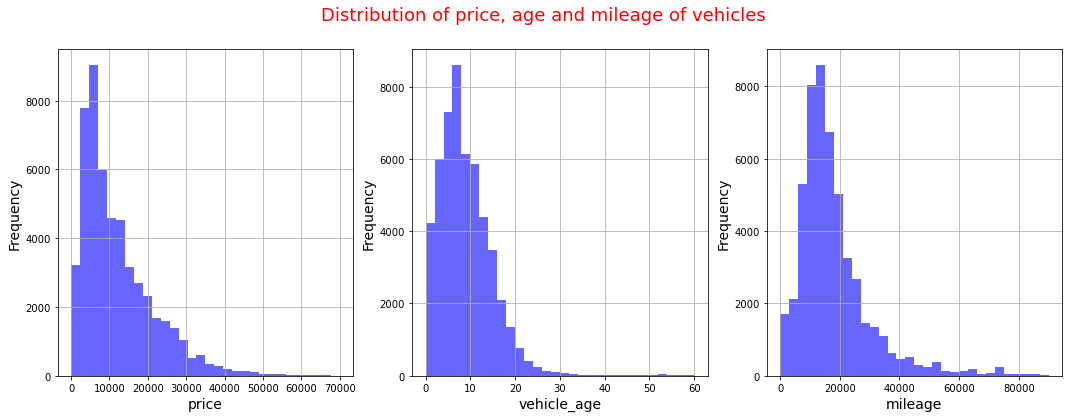

In [82]:
# plot histogram subplots for price, vehicle_age and mileage columns using a for loop
fig, axes= plt.subplots(1, 3, figsize=(18, 6))

cols=['price','vehicle_age','mileage']
ranges=[(0, 70000), (0, 60), (0, 90000)]

for i, col in enumerate(cols):
    axes[i].hist(ads[col], bins=30, alpha=0.6, color='blue', range=ranges[i])
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].grid(True)
    plt.suptitle('Distribution of price, age and mileage of vehicles', fontsize=18, color='red')

> From descriptive statistics we know that there extremely large values for price, vehicle_age and mileage columns. But for the sake of better visibility, we have chosen specific ranges for the x-axis. Another common thing about these three columns is that their mean and median values differentiate a lot as we saw in descriptive statistics. That means, their distribution is not normal. Histograms also show us that the distributions are as follow:
- price: from 0 to >70000. Most vehicles listed on the website are between price of 5k to 20k;
- vehicle_age: age of vehicles also span from new (0 years old) to >60 years old. However, most of the vehicles are 4-12 years old;
- mileage: vehicles were driven from 0 to >8000 miles (or km) yearly. However, most of them were between 10k-21k miles (or km).

> Now let's use similar *for loop* as above and plot histogram for *cylinders and condition* columns. Note that, condition and cylinder columns don't have many unique values, therefore we will choose the fewer number of *bins* and a small *range*.

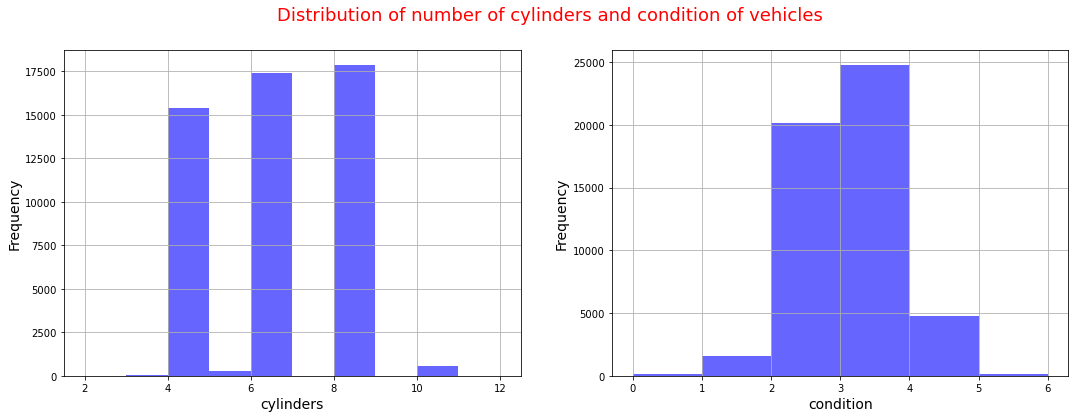

In [83]:
# plot histogram subplots for cylinders and condition columns using a for loop
fig, axes= plt.subplots(1, 2, figsize=(18, 6))

cols=['cylinders','condition']
ranges=[(2, 12), (0, 6)]
bin_num=[10, 6]

for i, col in enumerate(cols):
    axes[i].hist(ads[col], alpha=0.6, bins=bin_num[i], color='blue', range=ranges[i])
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].grid(True)
    plt.suptitle('Distribution of number of cylinders and condition of vehicles', fontsize=18, color='red')

> well, most of the vehicles are equipped with 4, 6, or 8 cylinders. A very small number of vehicles have cylinders like 3, 5, or 10. On another hand, the condition of cars are mostly excellent (2) or good (3). There are very few new (0) or salvage (5) vehicles are listed on the website, which means these new and salvage vehicles led to abnormally high and low prices for vehicles as well as mileage (age at the same time).

### 4.2 Determine and remove outliers
We have observed from the above histograms that there extremely high and low values (outliers) in our data which led to the large difference between mean and median values. Let's try to understand these outliers better by plotting box plots then we will calculate the upper limits and lower limits (if any) for our columns. Then we will set these limits for slicing our dataset.

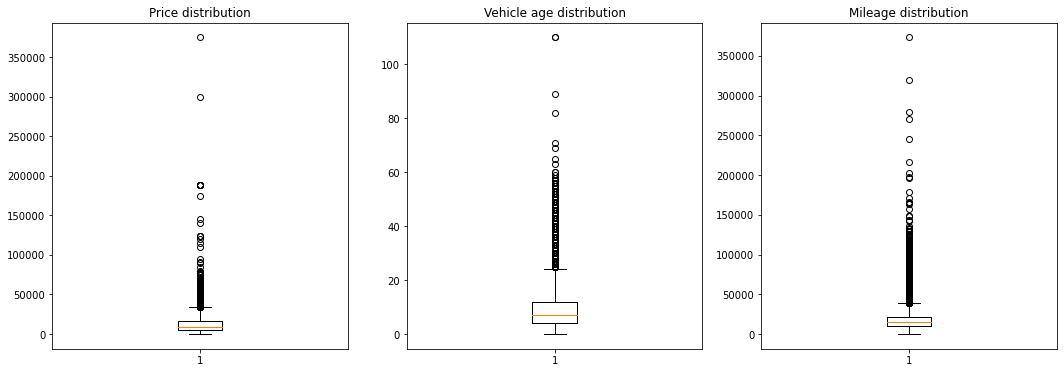

In [84]:
# plot box subplots for price, vehicle_age and mileage columns
fig, axs= plt.subplots(1, 3, figsize=(18, 6))

axs[0].boxplot(ads['price'])
axs[0].set_title('Price distribution')
axs[1].boxplot(ads['vehicle_age'])
axs[1].set_title('Vehicle age distribution')
axs[2].boxplot(ads['mileage'])
axs[2].set_title('Mileage distribution')
plt.show()

> Wow, we have a lot of outliers, especially extremely high values. Let's calculate a point where after this point all values will be accepted as outliers. For this, we will use the Q3+1.5*IQR equation.

In [85]:
# calculate upper limits for price, vehicle_age and mileage columns
for i in ['price', 'vehicle_age', 'mileage']:
    Q1 = ads[i].quantile(0.25)
    Q3 = ads[i].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5*IQR
    print('=========' + i + '========')
    print('upper_'+str(i), '=', upper_limit)
    print()

=========price========
upper_price = 34597.5

=========vehicle_age========
upper_vehicle_age = 24.0

=========mileage========
upper_mileage = 38771.5



> Now we can remove all rows which exceed the above values. Before slicing our data, let's check the cylinders and condition columns. For this, we will not plot a box plot, because these columns have a limited number of unique values already, so we will simply count the number of each unique value per column. And then we will remove unique values with very few existences in the slicing of data.

In [86]:
# number of unique values in the cylinders column
ads.cylinders.value_counts()

8     17859
6     17391
4     15414
10      553
5       272
3        34
12        2
Name: cylinders, dtype: int64

In [87]:
# number of unique values in the condition column
ads.condition.value_counts()

3    24773
2    20145
4     4742
1     1607
5      143
0      115
Name: condition, dtype: int64

> We have all values which we can set as an upper limit. Using query() function, let's select rows where price < 34597, vehicle_age <24, mileage < 38771, cylinders between 3 and 12, and condition between 0 and 5. Also, we will calculate how much data we are going to lose by applying that filters.

In [88]:
subset_ads = ads.query('price < 34597 and vehicle_age < 24 and mileage < 38771 and \
                        3 < cylinders < 12 and 0 < condition < 5')
print('Number of rows in original dataset:',len(ads))
print('Number of rows in filtered dataset:', len(subset_ads))
print('Percentage of rows left after slicing: {:.2%}'.format(len(subset_ads)/len(ads)))

Number of rows in original dataset: 51525
Number of rows in filtered dataset: 45572
Percentage of rows left after slicing: 88.45%


> By removing extreme values, we lost **11.5%** out of whole data. This is not something we can simply ignore, but we still have more than 45k observations. So, we can remove outliers. 

### 4.3 Histograms for filtered data
we will make histograms as we did in the **section 4.1** for our filtered data.

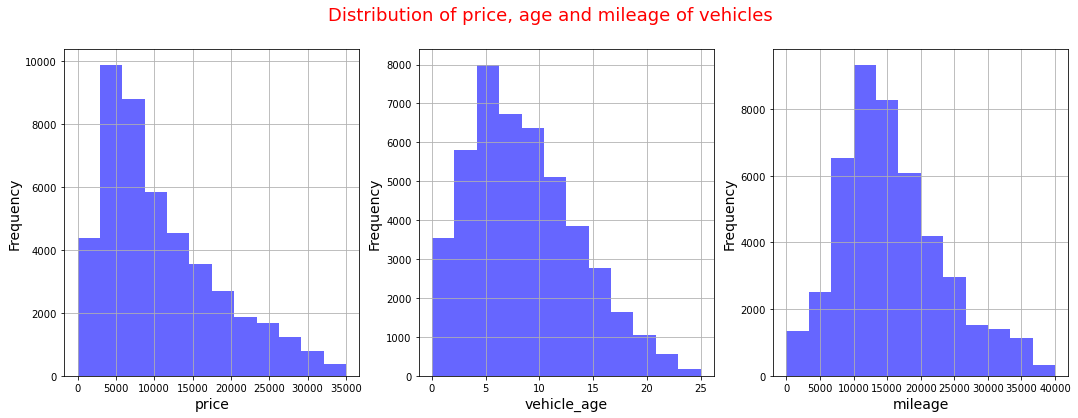

In [89]:
# plot histogram subplots for price, vehicle_age and mileage columns using a for loop
fig, axes= plt.subplots(1, 3, figsize=(18, 6))

cols=['price','vehicle_age','mileage']
ranges=[(0, 35000), (0, 25), (0, 40000)]

for i, col in enumerate(cols):
    axes[i].hist(subset_ads[col], bins=12, alpha=0.6, color='blue', range=ranges[i])
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].grid(True)
    plt.suptitle('Distribution of price, age and mileage of vehicles', fontsize=18, color='red')

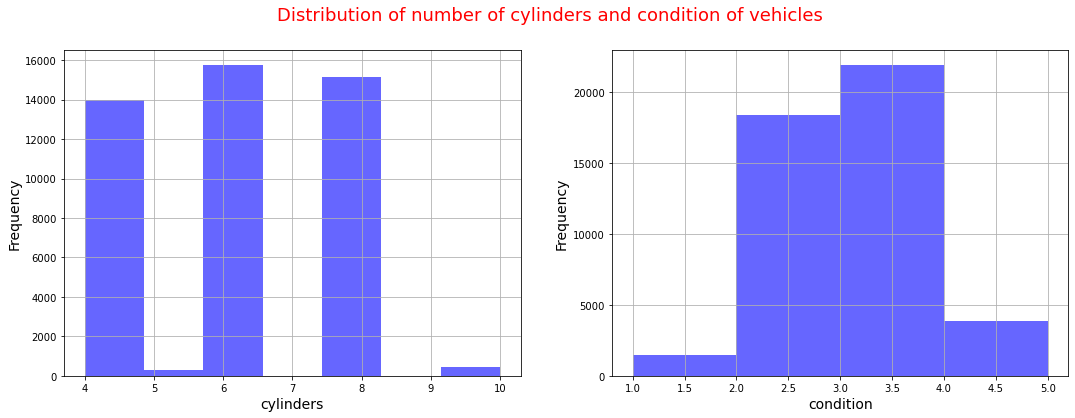

In [90]:
# plot histogram subplots for cylinders and condition columns using a for loop
fig, axes= plt.subplots(1, 2, figsize=(18, 6))

cols=['cylinders','condition']
ranges=[(4, 10), (1, 5)]
bin_num=[7, 4]

for i, col in enumerate(cols):
    axes[i].hist(subset_ads[col], alpha=0.6, bins=bin_num[i], color='blue', range=ranges[i])
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Frequency', fontsize=14)
    axes[i].grid(True)
    plt.suptitle('Distribution of number of cylinders and condition of vehicles', fontsize=18, color='red')

> We have filtered our data and plotted new histograms for each column. And our comments on each histogram goes as follow:
- **price**: The most popular price is ca. 5k. Besides, cheap vehicles (i.e. <5k) and vehicles that costs ca 15k make most of the vehicles.
- **age of vehicles**: The most popular vehicles are 5 years old. However, vehicles that are between 0-15 years old make most of the vehicles in the data.
- **mileage**: The most popular vehicles have been driven 12.5k miles(or km), whereas vehicles that have been driven between 5k-25k make most of the vehicles on the website.
- **cylinders**: Vehicles that were equipped with 4, 6, or 8 cylinders make almost all of the vehicles listed on the website. That is because of technical reasons, i.e. efficiency of vehicles are high when they are equipped with 4 or 6 cylinders than 5 cylinders. But for special vehicles, like for buses, an unusual number of cylinders also exist, though they are not so much.
- **condition**: Pretty much of vehicles are either in excellent or good condition. Like new vehicles are also listed more frequently than vehicles in fair condition.

### 4.4 Lifetime of ads
The next interesting thing is how fast vehicles are sold on the website. Or which factors affect most the speed of the sale? First of all, let's make a histogram that will show us the spread of days that ads were on the website before they sold. We will then see how many days (mean and median) the vehicles remain on the website before they are sold.

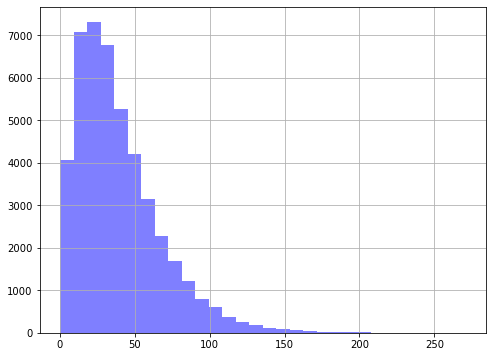

In [91]:
#
subset_ads.days_listed.hist(bins=30, color='blue', alpha=0.5, figsize=(8, 6))
plt.show()

In [92]:
subset_ads.days_listed.describe()

count    45572.000000
mean        39.547112
std         28.238685
min          0.000000
25%         19.000000
50%         33.000000
75%         53.000000
max        271.000000
Name: days_listed, dtype: float64

> 75% of the vehicles are usually sold in less than 53 days. There are even vehicles sold on the day they are listed. However, on average ads remains 39 days on the website before they were bought. There are some extremely long remained ads on the website, up to 271 days. It is interesting to find out what makes the sale fast or slow, right?

> To analyze the correlation of columns with each other, we can use **corr()** function of pandas and for the sake of visual perception, we will beautify the table as follows.

In [93]:
# find correlation of numerical columns and change the style
corr = subset_ads.corr()
corr.style.background_gradient(cmap='BrBG', axis=None).set_precision(2)

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,p_weekday,p_month,p_year,vehicle_age,mileage
price,1.00,0.51,0.20,0.31,-0.42,0.33,-0.00,0.00,-0.02,0.02,-0.51,0.20
model_year,0.51,1.00,0.31,-0.15,-0.56,-0.02,-0.00,0.00,-0.04,0.04,-1.00,0.53
condition,0.20,0.31,1.00,-0.08,-0.32,-0.00,0.00,0.01,-0.01,0.01,-0.31,0.06
cylinders,0.31,-0.15,-0.08,1.00,0.12,0.42,0.00,-0.00,0.00,-0.00,0.15,-0.05
odometer,-0.42,-0.56,-0.32,0.12,1.00,0.05,0.01,0.00,0.02,-0.01,0.56,0.23
is_4wd,0.33,-0.02,-0.00,0.42,0.05,1.00,0.00,0.00,0.00,-0.00,0.02,0.04
days_listed,-0.00,-0.00,0.00,0.00,0.01,0.00,1.00,0.00,-0.01,0.01,0.00,-0.00
p_weekday,0.00,0.00,0.01,-0.00,0.00,0.00,0.00,1.00,0.01,-0.01,-0.00,-0.00
p_month,-0.02,-0.04,-0.01,0.00,0.02,0.00,-0.01,0.01,1.00,-0.82,-0.04,0.08
p_year,0.02,0.04,0.01,-0.00,-0.01,-0.00,0.01,-0.01,-0.82,1.00,0.05,-0.10


> What?! Seems like our data kidding with us :). There is hardly any correlation between ** days_listed ** and other columns. This means that almost nothing can control the pace of the sale. But actually, this makes sense, right?! Let's imagine there is an expensive car listed on the website. We might think, "Oh no, this car will stay there forever." But what if this car is a Lamborghini or some other very cool car, the real retail price is much more expensive? In this case, someone who really wants to buy such a cool car can buy that car very quickly.

### 4.5 Vehilce type prices
Ok, now we are wondering which vehicle types cost how much and how many of those vehicle types are listed on the website. Let's get our hands dirty with this task. First, we will make a pivot table where the indices are the vehicle types and the columns are the average price and the number of specific vehicle type. Then we will make a abr plot using the pivot table.

In [94]:
# pivot table for vehicle types with average price and count
vehicle_type_pivot = subset_ads.pivot_table(index='type', values='price', aggfunc=['count', 'mean'])
vehicle_type_pivot.columns=['number_of_ads','avg_price']
vehicle_type_pivot

,number_of_ads,avg_price
type,,
SUV,11290,10047.381045
bus,21,18107.428571
convertible,327,12948.642202
coupe,1907,12935.231778
hatchback,947,6532.940866
mini-van,1071,7546.303455
offroad,180,13894.538889
other,216,9917.449074
pickup,5993,14359.589688


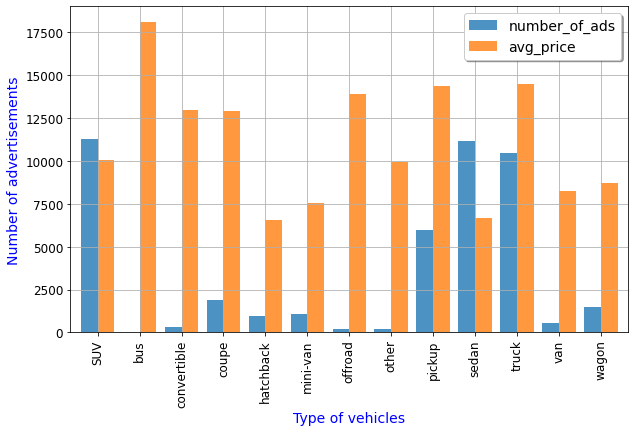

In [95]:
# bar plot with customization of label, ticks and legend
vehicle_type_pivot.plot(kind='bar', alpha=0.8, width=0.8, figsize=(10,6), grid=True)
plt.xlabel('Type of vehicles', fontsize=14, color='blue')
plt.ylabel('Number of advertisements', fontsize=14, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, frameon=True, shadow=True, fancybox=True)
plt.show()

> Well, buses are so pricey, but they are not listed so frequently. Only several of them exist in the data. But how about vehicles types both popular and cost more?! Truck and SUV are both relatively expensive and a lot of are listed. Sedans are also listed more frequently than trucks, but they are cheaper than trucks. Based on the number of ads per type, we will choose SUV and sedan for our upcoming task.

### 4.6 Factors affecting the price
We will take each of the popular types we detected (SUV and sedan) at the previous stage and study whether the price depends on age, mileage, condition, transmission type, and color. For categorical variables (transmission type and color), we will plot box charts, and create scatterplots for the rest. Before we dive in, let's make a new dataset that includes only the relevant vehicle types and required columns.

In [96]:
# slice subset_ads data using query() for SUV and sedan types. Then take only in focus columns
popular_vehicles = subset_ads.query('type in ["SUV", "sedan"]')
popular_vehicles = popular_vehicles[['type','price','vehicle_age','mileage','condition'\
                                     ,'transmission','paint_color']]

#check the changes
popular_vehicles.sample(5)

,type,price,vehicle_age,mileage,condition,transmission,paint_color
22393,SUV,7650,11,19230,2,automatic,blue
18762,sedan,1500,7,20225,2,automatic,red
10466,sedan,4950,6,17371,3,automatic,red
26525,SUV,8995,6,17135,3,automatic,black
31681,SUV,4300,14,10690,3,automatic,unknwown


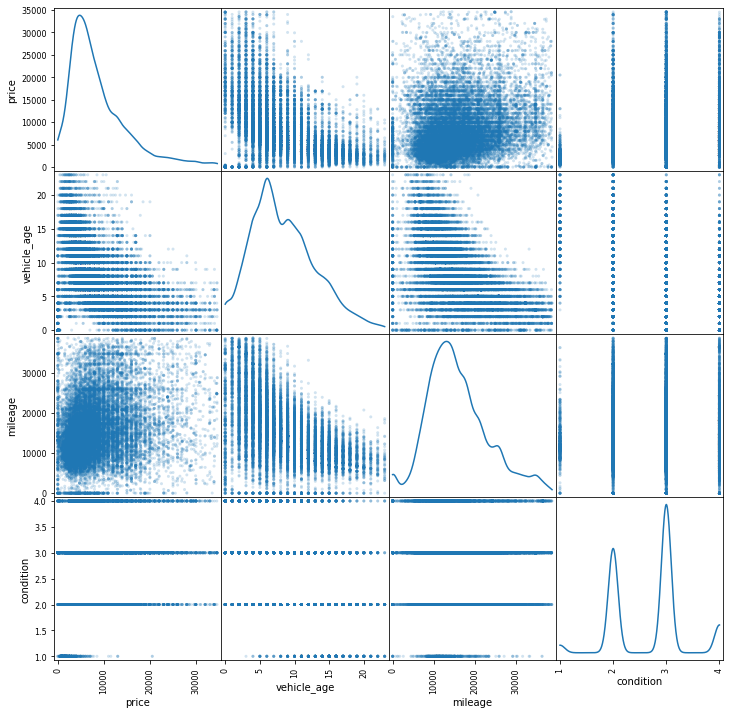

In [97]:
# scatter matrix for numerical columns
pd.plotting.scatter_matrix(popular_vehicles, alpha=0.2, figsize=(12, 12), diagonal="kde")
plt.show()

> Only price and age of vehicle has a clear trend, where older the vehicle its price goes down. Although, majority of vehicles which has lower mileage cost cheap, there are many exceptions where low mileage vehicles cost for cheap or vice versa. For the condition and price relation, we can only say that vehicles with the fair condition are cheap. But for better visualization, a box plot for the condition column makes more sense.

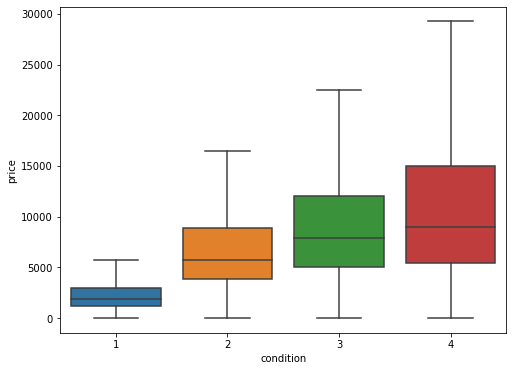

In [98]:
# box plot for condition vs price columns, hide outliers
plt.figure(figsize=(8,6))
sns.boxplot(x="condition", y="price", data=popular_vehicles, showfliers=False)
plt.show()

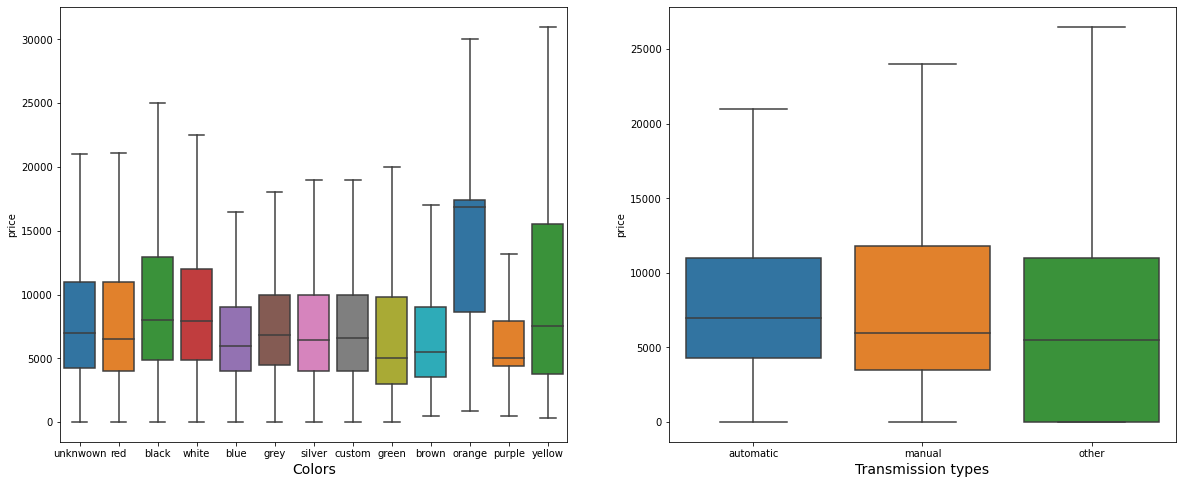

In [99]:
# box subplots for paint_color and transmission columns with price variation
#hide outlier for better visualization
fig, axs = plt.subplots(1, 2, figsize=(20,8) )
sns.boxplot(data=popular_vehicles, x="paint_color", y="price",  palette='tab10', showfliers=False, ax=axs[0])
axs[0].set_xlabel('Colors', fontsize=14)
sns.boxplot(x="transmission", y="price", data=popular_vehicles, showfliers=False, ax=axs[1])
axs[1].set_xlabel('Transmission types', fontsize=14)
plt.show()

In [100]:
# check number of vehicle in each color
popular_vehicles.paint_color.value_counts()

unknwown    4031
black       3572
silver      3355
white       3121
grey        2555
blue        2124
red         1725
green        611
brown        599
custom       556
orange        82
yellow        65
purple        64
Name: paint_color, dtype: int64

In [101]:
# check number of vehicle in each transmission
popular_vehicles.transmission.value_counts()

automatic    21193
manual        1018
other          249
Name: transmission, dtype: int64

> 
- Compared to the scatter plot of **price vs condition**, the box plot more clearly shows price change with the condition. The median price of vehicles increased from fair to like-new condition. Also, price distribution strongly depends on the condition. Better the condition more the wider the price distribution or vice versa.

- Median prices of vehicles for each **color are between 5k to 10k**, except orange colored vehicles. The most popular colours are black, white, silver, grey, blue, red. Black colored vehicles more likely to be expensive, whereas blue ones less likely to be expensive relative to black. Less common colors, such as orange, purple or yellow colored vehicles have unusually expensive prices, which might be caused due to the low number of such vehicles on the list (Law of Large Number!).

- Median price of automatic vehicles is a little higher than manual vehicles, while the overall price distribution of manual vehicles is wider than automatic vehicles. However, the number of automatic vehicles are almost 20 times more than manual ones. That makes the distribution of automatic vehicles more bell-shaped (normal distribution). There are 90 times fewer vehicles with transmission type 'other' compared to automatic, which makes its box-whisker plot so weird (Law of Large Number!).

### 4.7 Conclusion
- Histograms were plotted from original data, then outliers were detected and removed to make the final calculations realistic. 
- Lifetime of ads was investigated to find a relationship with other columns. But there was no explanation found that makes sales faster or slower. 
- Mostly sold vehicle types were detected as SUV, sedan, truck and pickup.
- Factors affecting the price of SUV and Sedan vehicles were studied according to their age, mileage, transmission type, color and condition. There is a negative correlation between the price and the age of the vehicle. Box plots showed that black vehicles, automatic transmission and like-new vehicles are usually expensive

## 5. Overall conclusion

Dataset was successfully loaded and it had ```13 columns``` with ```51525``` rows.

In total 5 columns (is_4wd, model_year, cylinders, odometer and paint_color) had missing values. These missing values most likely originating from the users, people who are placing the advertisement. Missing values might be originating from the people who are filling the questionaries. Different methods were applied to fill missing values depending on the column, such as missing values of **is_4wd** column was filled with 0, which represents False, because all non-missing rows were containing 1, which represents True. **model_year and odometer** columns were filled using median values of vehicles depending on the **contidion** column. The missing values of the **cylinders** column was filled using median values of each type of vehicle from the **type** column. The missing values of **paint_color** were filled with the word "unknown because it can be predicted from other columns.

```model_year``` and ```date_posted``` columns had ```float64``` and ```int64``` data type, respectively. However, these columns were containing years and year-month-day, respectively. Therefore data type of that columns was changed to ```datetime64``` data type.

No duplicated rows were detected in the dataset!

The new columns added that containing the day of the week, month and year when add was posted. For this dates from the ```date_posted``` column was utilized. A new column called ```vehicle_age``` was added to the data by simply subtracting the ```model_year``` column from ```p_year```,  which is the year of posting the ad. Average mileage per year was obtained by dividing the ```odometer``` column by the ```vehicle_age``` column. However, there were new vehicles with age equal to zero, in such cases mileage was directly copied from the ```odometer``` column. String values in the ```condition``` column were converted to numeric scale:  new = 5 like new = 4 excellent = 3 good = 2 fair = 1 salvage = 0.

Histograms were plotted for ```price```, ```vehicle's age```, ```mileage```, ```cylinders``` and ```condition``` columns of data, then outliers were detected and removed to make the final calculations realistic. All rows which does not meet following condition were removed: **price < 34597 and vehicle_age < 24 and mileage < 38771 and 3 < cylinders < 12 and 0 < condition < 5**. This filtered data was utilized for the rest steps of the project.

The lifetime of ads was investigated to find a relationship with other columns. But there was no explanation found that makes sales faster or slower.

Mostly sold vehicle types were detected as SUV, sedan, truck and pickup.

Factors affecting the price of SUV and Sedan vehicles were studied according to their age, mileage, transmission type, color and condition. There is a negative correlation between the price and the age of the vehicle. Box plots showed that black vehicles, automatic transmission and like-new vehicles are usually expensive.